<a href="https://colab.research.google.com/github/ParsecInstitute/Astromatic2022/blob/problem8/Problems/P8_camels/Problem8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 8

Problem description
[Camel simulation](https://www.camel-simulations.org/)

Goals

In [120]:
import torch
import torch.optim as optim
from torch import nn
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.colors import LogNorm
plt.style.use("classic")
params = {
    'legend.fontsize': 15,
    'figure.figsize': (8, 8),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 15 # for annotate
}
pylab.rcParams.update(params)

DTYPE = torch.float32
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
# Helper functions for plotting power spectra and transfer functions
class PowerSpectrum:
    def __init__(self, pixels, bins, dtype=DTYPE):
        assert bins < pixels//2
        self.pixels = pixels
        self.bins = bins
        self.masks = self.build_azimuthal_masks()

    def build_azimuthal_masks(self):
        x = torch.range(-self.pixels//2, self.pixels//2 - 1) + 0.5
        x, y = torch.meshgrid(x, x)
        r = torch.sqrt(x**2 + y**2)
        _, edges = np.histogram(np.arange(self.pixels//2), bins=self.bins)
        masks = torch.zeros(size=[self.bins, self.pixels, self.pixels], dtype=DTYPE)
        for i in range(self.bins):
            mask = ((r > edges[i]) & (r < edges[i + 1])).float()
            masks[i] = mask
        return masks

    def power_spectrum(self, x):
        norm = torch.sqrt(torch.sum(torch.abs(x)**2, dim=(1, 2), keepdims=True))
        x_hat = torch.fft.fftshift(torch.fft.fft2(x/norm))
        ps = torch.zeros(size=[x.shape[0], self.bins], dtype=DTYPE)
        for i in range(self.bins):
            ps[:, i] = torch.sum(torch.abs(x_hat)**2 * self.masks[i][None, ...], dim=(1, 2)) / torch.sum(self.masks[i])
        return ps

    def cross_power_spectrum(self, x, y):
        x_hat = torch.fft.fftshift(torch.fft.fft2((x/torch.sqrt(torch.sum(torch.abs(x)**2, dim=(1, 2), keepdims=True)))))
        y_hat = torch.fft.fftshift(torch.fft.fft2(y/torch.sqrt(torch.sum(torch.abs(y)**2, dim=(1, 2), keepdims=True))))
        ps = torch.zeros(size=[x.shape[0], self.bins], dtype=DTYPE)
        for i in range(self.bins):
            ps[:, i] = torch.sum(torch.abs(torch.conj(x_hat) * y_hat) * self.masks[i][None, ...], dim=(1, 2)) / torch.sum(self.masks[i])
        return ps

    def cross_correlation_coefficient(self, x, y):
        Pxy = self.cross_power_spectrum(x, y)
        Pxx = self.power_spectrum(x)
        Pyy = self.power_spectrum(y)
        gamma = Pxy / torch.sqrt(Pxx * Pyy + 1e-16)
        return gamma
    
    def transfer_coefficient(self, x, y):
        Pxx = self.power_spectrum(x)
        Pyy = self.power_spectrum(y)
        return Pxx / (Pyy + 1e-16)

In [105]:
%cd drive/MyDrive/Astromatic2022-Data/Problem\ 8/
!unzip illustrisTNG.zip
path_to_total_mass_maps = "Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/Maps_HI_IllustrisTNG_LH_z=0.00.npy"
path_to_dark_matter_maps = ""
path_to_cosmo_params = "params_IllustrisTNG.txt"

# Datasets

In [180]:
class IllustrisFieldtoField(Dataset):
    def __init__(self, path_to_dm_only_npy, path_to_total_mass_npy, crop_size=128, device=DEVICE):
      """
      crop_size must be a power of 2 smaller or equal to 256 (we suggest 128 to start, and smaller values if training takes too long, like 64 or 32y)

      path_to_dm_only_npy: Input
      path_to_total_mass_npy: Labels
      """
      self.dm_maps = np.load(path_to_dm_only_npy, mmap_mode='r+')
      self.tm_maps = np.load(path_to_total_mass_npy, mmap_mode='r+')
      self.size = self.dm_maps.shape[0] * (256 // crop_size)**2
      self.modulo = self.dm_maps.shape[0]
      self.crop_size = crop_size

    def __len__(self):
      return self.size

    def __getitem__(self, index):
      """
      This takes the 15000, 256x256 maps, and splits each into (256 / crop_size)**2 maps of 
      size crop_size x crop_size.
      """
      i = index // self.modulo
      ell = self.crop_size
      m = 256 // ell
      # slow moving index
      j = (i // m) * ell
      jp1 = (i // m + 1) * ell
      # fast moving index
      k = (i % m) * ell
      kp1 = (i % m + 1) * ell

      X = torch.Tensor(self.dm_maps[index, j: jp1, k: kp1]).float().to(DEVICE)
      Y = torch.Tensor(self.tm_maps[index, j: jp1, k: kp1]).float().to(DEVICE)
      return X, Y


class IllustrisFieldtoCosmo(Dataset):
    def __init__(self, path_to_dm_only_npy, path_to_params, crop_size=128, device=DEVICE):
      """
      path_to_dm_only_npy: Input
      path_to_total_mass_npy: Labels
      """
      self.dm_maps = np.load(path_to_dm_only_npy, mmap_mode='r+')
      self.params = np.loadtxt(path_to_params)
      self.size = self.dm_maps.shape[0] * (256 // crop_size)**2
      self.modulo = self.dm_maps.shape[0]
      self.crop_size = crop_size

      # 0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2)
      # we want to infer the first 2
      self.params = self.params[:, :2]

    def __len__(self):
      return self.size

    def preprocess_labels(self, params):
      #preprocessing for full parameter space
      # minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
      # maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
      minimum = np.array([0.1, 0.6])
      maximum = np.array([0.5, 1.0])
      return (params - minimum)/(maximum - minimum) # renormalize in the range [0, 1]

    def __getitem__(self, index):
      """
      This takes the 15000, 256x256 maps, and splits each into (256 / crop_size)**2 maps of 
      size crop_size x crop_size. Then associate each map to its cosmology.
      """ 
      i = index // self.modulo
      ell = self.crop_size
      m = 256 // ell
      # slow moving index
      j = (i // m) * ell
      jp1 = (i // m + 1) * ell
      # fast moving index
      k = (i % m) * ell
      kp1 = (i % m + 1) * ell
      # param index
      param_index = (index % self.dm_maps.shape[0]) // 15
      X = torch.Tensor(self.dm_maps[index, j: jp1, k: kp1]).float().to(DEVICE)
      Y = torch.Tensor(self.preprocess_labels(self.params[param_index])).float().to(DEVICE)
      return X, Y


# Exploration
Simulations have a comoving volume of $(25\, \mathrm{Mpc}\, h^{-1})^3$

Each map was realized with different cosmological parameters and different seeds. 

$\sigma_8 \sim \mathcal{U}(0.1,\, 0.6)$

$\Omega_m \sim \mathcal{U}(0.5, 1)$

In [206]:
# this reads the dataset without loading into memory, this is also used in the dataset classes
maps = np.load(path_to_total_mass_maps, mmap_mode='r+')
params = np.loadtxt(path_to_cosmo_params)
FOV = 25 # Mpc / h

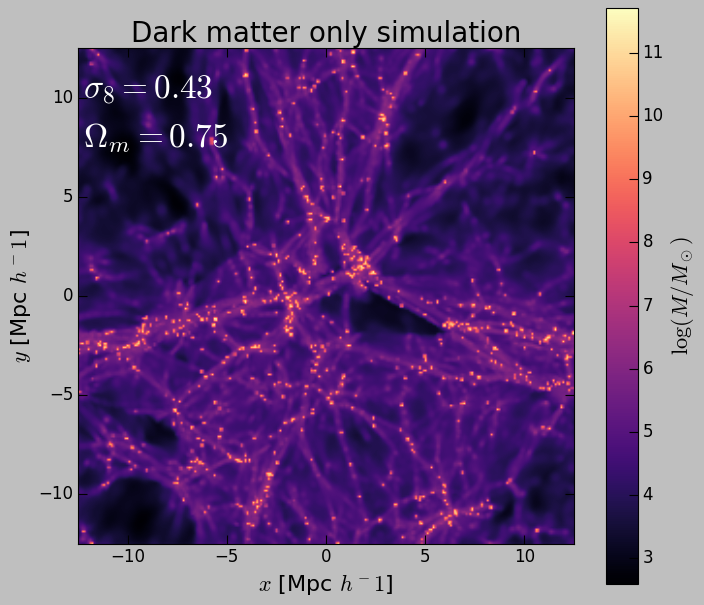

In [210]:
index = 42
cosmo_index = index // 15 # hard coded rule from the data

extent = [-FOV/2,FOV/2] * 2
im = plt.imshow(np.log10(maps[42]), cmap="magma", origin='lower', extent=extent)
plt.title("Dark matter only simulation")
plt.xlabel("$x$ [Mpc $h^-1$]")
plt.ylabel("$y$ [Mpc $h^-1$]")
plt.annotate(r"$\sigma_8 = %.2f$" % params[cosmo_index, 0], xy=(0.01, 0.9), xycoords="axes fraction", color="w", fontsize=30)
plt.annotate(r"$\Omega_m= %.2f$" % params[cosmo_index, 1], xy=(0.01, 0.8), xycoords="axes fraction", color="w", fontsize=30)
cax = plt.axes([0.95, 0.05, 0.05, 0.9])
plt.colorbar(mappable=im, cax=cax, label="$\log(M / M_\odot)$");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Power spectrum')

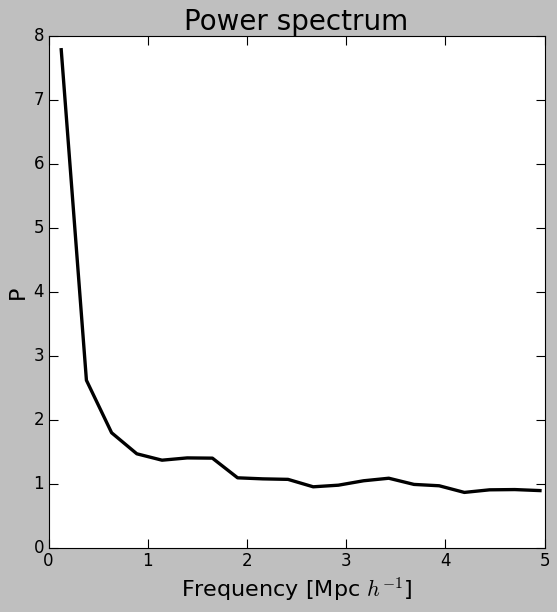

In [204]:
ps = PowerSpectrum(pixels=256, bins=20)
P = ps.power_spectrum(torch.Tensor(maps[42])[None].float().to(DEVICE))[0]

_, f = np.histogram(np.fft.fftfreq(ps.pixels)[:ps.pixels//2], bins=ps.bins)
f = (f[:-1] + f[1:]) / 2 * ps.pixels / FOV
plt.plot(f, P, "k-", lw=3)
plt.xlabel("Frequency [Mpc $h^{-1}$]")
plt.ylabel("P")
plt.title("Power spectrum")

# Neural network architectures

In [ ]:
# class Unet(nn.Module):
#   def __init__(self):
#       # Make your architecture here
#   def call(self, x):
#     # define the flow of operations here
#     # return y

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#         # Make your architecture here
#     def forward(self, image):
#         # define the flow of operations here
#         # return y

# Training loop

In [117]:
# EPOCHS = 10 # number of loop over the dataset
# TRAIN_SPLIT = 0.9 # fraction of the dataset used for training
# BATCH_SIZE = 10

# dataset = IllustrisFieldtoCosmo(path_to_total_mass_maps, path_to_cosmo_params, crop_size=32)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# net = ...
# trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# for epoch in range(EPOCHS):
    # reset your metrics here  
    # running_loss = 0.0 
    # for i, (X, Y) in enumerate(trainloader):

        # zero the parameter gradients
        # optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = net(inputs)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()

# Results